# 1. Data Imports and setting environment

**Project:** Predicting ventilator requirements for COVID‑19 (Target: `INTUBATED`)  
**Notebook:** `01_eda.ipynb` (Load → Clean → EDA)  

> **Goal:** Produce a clean, reproducible EDA workflow and save artefacts (clean dataset + plots + summaries) to `notebooks/outputs/`.


In [1]:
# ---------------------------------------------------------------------
# 1.1 Imports
# ---------------------------------------------------------------------

import os
from pathlib import Path
import json
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


In [ ]:
# ---------------------------------------------------------------------
# 1.2 Reproducibility + paths
# ---------------------------------------------------------------------
SEED = 42
np.random.seed(SEED)

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data" / "raw"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
FIG_DIR = OUTPUT_DIR / "figures"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Update this if your dataset is stored elsewhere
DATA_PATH = DATA_DIR / "Covid_Data.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH:", DATA_PATH)
print("OUTPUT_DIR:", OUTPUT_DIR)


# 2.0 Data Loading

**Assumption:** raw data is in `data/Covid Data.csv`.

- If you're running in Colab, mount Drive and set `DATA_PATH` accordingly.
- If your file is named differently, update the `DATA_PATH` cell above.


In [3]:
# ---------------------------------------------------------------------
# 2.1 Load raw data
# ---------------------------------------------------------------------
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Could not find dataset at {DATA_PATH}. "
        "Place the file under ./data/ or update DATA_PATH."
    )

df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head()


Shape: (1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,2,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,2,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,2,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,2,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,2,2,2,1,2,2,2,2,2,3,97


# 3.0 Dataset schema notes (Kaggle: `meirnizri/covid19-dataset`)

This project uses the **Mexico COVID‑19 clinical dataset** distributed on Kaggle.

**Important coding conventions (used throughout the dataset):**
- Many clinical indicator fields use: **1 = Yes**, **2 = No**
- Values such as **97 / 98 / 99** indicate **missing / not specified** (treated as `NaN`)
- `DATE_DIED` often uses **`9999-99-99`** to indicate the patient is alive (no death date recorded)

We apply *minimal, transparent* recoding below to support reproducible modelling.


In [4]:
# ---------------------------------------------------------------------
# 3.1 Standardise columns (lowercase) and inspect
# ---------------------------------------------------------------------
df = df_raw.copy()
df.columns = [c.strip().lower() for c in df.columns]

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (1048575, 21)
Columns: ['usmer', 'medical_unit', 'sex', 'patient_type', 'date_died', 'intubed', 'pneumonia', 'age', 'pregnant', 'diabetes', 'copd', 'asthma', 'inmsupr', 'hipertension', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'clasiffication_final', 'icu']


,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,copd,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu
0,2,1,1,1,03/05/2020,97,1,65,2,2,2,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,2,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,2,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,2,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,2,2,2,1,2,2,2,2,2,3,97


In [5]:
# ---------------------------------------------------------------------
# 3.2 Recoding helpers (1/2/97/98/99)
# ---------------------------------------------------------------------
UNKNOWN_CODES = {97, 98, 99}

def recode_yes_no(s: pd.Series) -> pd.Series:
    """Map {1:1, 2:0, 97/98/99:NaN}."""
    x = pd.to_numeric(s, errors="coerce")
    x = x.where(~x.isin(list(UNKNOWN_CODES)), np.nan)
    return x.map({1: 1, 2: 0})

def coerce_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")


In [6]:
# ---------------------------------------------------------------------
# 3.3 Create modelling target: intubated (from 'intubed')
# ---------------------------------------------------------------------
if "intubed" not in df.columns:
    raise KeyError("Expected column 'INTUBED' (-> 'intubed' after lowercasing) not found.")

df["intubated"] = recode_yes_no(df["intubed"])

# For modelling, we remove rows where the target is unknown (97/98/99)
before = len(df)
df = df.dropna(subset=["intubated"]).copy()
df["intubated"] = df["intubated"].astype(int)

print(f"Rows dropped (unknown intubation status): {before - len(df):,}")
print("Target positive rate (intubated=1):", df["intubated"].mean())
df[["intubed", "intubated"]].head()


Rows dropped (unknown intubation status): 855,869
Target positive rate (intubated=1): 0.174649466025967


,intubed,intubated
2,1,1
5,2,0
8,2,0
9,2,0
11,2,0


In [7]:
# ---------------------------------------------------------------------
# 3.4 Create a derived outcome: died (from 'date_died')
# ---------------------------------------------------------------------
# 9999-99-99 indicates the patient is alive (no death date recorded)
if "date_died" in df.columns:
    s = df["date_died"].astype(str)
    df["died"] = np.where(s.eq("9999-99-99") | s.eq("nan"), 0, 1).astype(int)
    df["date_died_parsed"] = pd.to_datetime(df["date_died"], errors="coerce")
    print("Derived died rate:", df["died"].mean())
else:
    print("Column 'DATE_DIED' not found (-> 'date_died'); skipping.")


Derived died rate: 0.35277573090614717


In [8]:
# ---------------------------------------------------------------------
# 3.5 Recode common yes/no indicator fields (if present)
# ---------------------------------------------------------------------
binary_like = [
    "pneumonia", "pregnant", "diabetes", "copd", "asthma", "inmsupr",
    "hypertension", "other_disease", "cardiovascular", "obesity",
    "renal_chronic", "tobacco", "icu"
]

present = [c for c in binary_like if c in df.columns]
print("Binary-like columns detected:", present)

for c in present:
    df[c] = recode_yes_no(df[c])

df[present].describe(include="all").T


Binary-like columns detected: ['pneumonia', 'pregnant', 'diabetes', 'copd', 'asthma', 'inmsupr', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'icu']


,count,mean,std,min,25%,50%,75%,max
pneumonia,192706.0,0.602021,0.489482,0.0,0.0,1.0,1.0,1.0
pregnant,77914.0,0.023179,0.150474,0.0,0.0,0.0,0.0,1.0
diabetes,191535.0,0.293821,0.455512,0.0,0.0,0.0,1.0,1.0
copd,191662.0,0.042606,0.201968,0.0,0.0,0.0,0.0,1.0
asthma,191663.0,0.024908,0.155846,0.0,0.0,0.0,0.0,1.0
inmsupr,191479.0,0.035581,0.185243,0.0,0.0,0.0,0.0,1.0
other_disease,190722.0,0.057765,0.233299,0.0,0.0,0.0,0.0,1.0
cardiovascular,191589.0,0.049711,0.217347,0.0,0.0,0.0,0.0,1.0
obesity,191610.0,0.201717,0.401283,0.0,0.0,0.0,0.0,1.0
renal_chronic,191653.0,0.059258,0.236108,0.0,0.0,0.0,0.0,1.0


In [9]:
# ---------------------------------------------------------------------
# 3.6 Coerce key numeric columns
# ---------------------------------------------------------------------
if "age" in df.columns:
    df["age"] = coerce_numeric(df["age"])

print("Shape after recoding:", df.shape)
df[["age", "intubated"]].head()


Shape after recoding: (192706, 24)


,age,intubated
2,55,1
5,40,0
8,37,0
9,25,0
11,24,0


In [10]:
# ---------------------------------------------------------------------
# 2.2 Quick schema check
# ---------------------------------------------------------------------
schema = {
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "columns": list(df.columns),
    "dtypes": {c: str(t) for c, t in df.dtypes.items()},
}
schema


{'n_rows': 192706,
 'n_cols': 24,
 'columns': ['usmer',
  'medical_unit',
  'sex',
  'patient_type',
  'date_died',
  'intubed',
  'pneumonia',
  'age',
  'pregnant',
  'diabetes',
  'copd',
  'asthma',
  'inmsupr',
  'hipertension',
  'other_disease',
  'cardiovascular',
  'obesity',
  'renal_chronic',
  'tobacco',
  'clasiffication_final',
  'icu',
  'intubated',
  'died',
  'date_died_parsed'],
 'dtypes': {'usmer': 'int64',
  'medical_unit': 'int64',
  'sex': 'int64',
  'patient_type': 'int64',
  'date_died': 'object',
  'intubed': 'int64',
  'pneumonia': 'int64',
  'age': 'int64',
  'pregnant': 'float64',
  'diabetes': 'float64',
  'copd': 'float64',
  'asthma': 'float64',
  'inmsupr': 'float64',
  'hipertension': 'int64',
  'other_disease': 'float64',
  'cardiovascular': 'float64',
  'obesity': 'float64',
  'renal_chronic': 'float64',
  'tobacco': 'float64',
  'clasiffication_final': 'int64',
  'icu': 'float64',
  'intubated': 'int64',
  'died': 'int64',
  'date_died_parsed': 'dat

# 3.0 Data Cleaning

This section applies **minimal, defensible cleaning** suitable for a portfolio repo:

- Standardise column names (snake_case)
- Harmonise target column name (`INTUBATED`)
- Convert obvious binary-coded medical fields into 0/1 where safe
- Keep a clear audit trail of what changed


In [11]:
# ---------------------------------------------------------------------
# 3.1 Helper functions
# ---------------------------------------------------------------------
def to_snake_case(name: str) -> str:
    name = name.strip().replace(" ", "_").replace("-", "_")
    # split camelCase / PascalCase
    out = []
    for ch in name:
        if ch.isupper() and out and out[-1] != "_":
            out.append("_")
        out.append(ch.lower())
    s = "".join(out)
    while "__" in s:
        s = s.replace("__", "_")
    return s

def safe_binary_map(series: pd.Series) -> pd.Series:
    """Map common binary encodings to 0/1 when unambiguous.
    Supports {0,1}, {1,2} (Mexico COVID dataset style), {yes,no}, {true,false}.
    Leaves series unchanged if mapping is ambiguous.
    """
    s = series.copy()
    if pd.api.types.is_numeric_dtype(s):
        vals = set(pd.Series(s.dropna().unique()).astype(int).tolist())
        if vals.issubset({0, 1}):
            return s.astype("Int64")
        if vals.issubset({1, 2}):
            return s.map({1: 1, 2: 0}).astype("Int64")
        return s
    # string-like
    lowered = s.astype(str).str.lower()
    uniq = set(lowered.dropna().unique().tolist())
    if uniq.issubset({"yes", "no"}):
        return lowered.map({"yes": 1, "no": 0}).astype("Int64")
    if uniq.issubset({"true", "false"}):
        return lowered.map({"true": 1, "false": 0}).astype("Int64")
    return s


In [12]:
# ---------------------------------------------------------------------
# 3.2 Standardise column names
# ---------------------------------------------------------------------
df = df_raw.copy()
df.columns = df.columns.str.strip().str.lower()   # keeps underscores correctly

print("Has column 'intubed'?", "intubed" in df.columns)
df.head()


UNKNOWN_CODES = {97, 98, 99}

def recode_yes_no(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    x = x.where(~x.isin(list(UNKNOWN_CODES)), np.nan)
    return x.map({1: 1, 2: 0})

# Create modelling target from intubed
df["intubated"] = recode_yes_no(df["intubed"])

# drop unknown target rows
df = df.dropna(subset=["intubated"]).copy()
df["intubated"] = df["intubated"].astype(int)

print("Target positive rate:", df["intubated"].mean())

Has column 'intubed'? True
Target positive rate: 0.174649466025967


In [13]:
# ---------------------------------------------------------------------
# 3.3 Basic missingness + drop rows with missing target (standard practice)
# ---------------------------------------------------------------------
if "intubated" not in df.columns:
    raise KeyError(
        "Target column not found. Expected 'INTUBATED' (or a close variant). "
        f"Columns available: {list(df.columns)[:30]} ..."
    )

missing_target = df["intubated"].isna().mean()
print(f"Missing target rate: {missing_target:.3%}")

df = df.dropna(subset=["intubated"]).reset_index(drop=True)
print("Shape after dropping missing target:", df.shape)


Missing target rate: 0.000%
Shape after dropping missing target: (192706, 22)


In [14]:
# ---------------------------------------------------------------------
# 3.4 Convert likely binary columns
#     (We apply a conservative rule: only map if unambiguous)
# ---------------------------------------------------------------------
binary_candidates = []
for col in df.columns:
    if col == "age":
        continue
    if df[col].nunique(dropna=True) <= 3:
        binary_candidates.append(col)

converted = []
for col in binary_candidates:
    before = df[col].copy()
    after = safe_binary_map(before)
    # mark as converted only if dtype changed to Int64 and values now in {0,1}
    if str(after.dtype) == "Int64":
        vals = set(after.dropna().astype(int).unique().tolist())
        if vals.issubset({0, 1}):
            df[col] = after
            converted.append(col)

print(f"Converted {len(converted)} columns to binary 0/1.")
converted[:25]


Converted 6 columns to binary 0/1.


['usmer', 'sex', 'patient_type', 'intubed', 'pneumonia', 'intubated']

# 4.0 Exploratory Data Analysis (EDA)

We’ll focus on EDA that directly helps modelling:

1. Target balance (class imbalance)
2. Missingness patterns
3. Age distribution / outliers (if present)
4. High-signal features (correlation / prevalence by class)

**Note:** Plots are saved into `notebooks/outputs/figures/`.


Target counts:


,count
intubated,
0,159050
1,33656


Positive rate (intubated=1): 17.465%


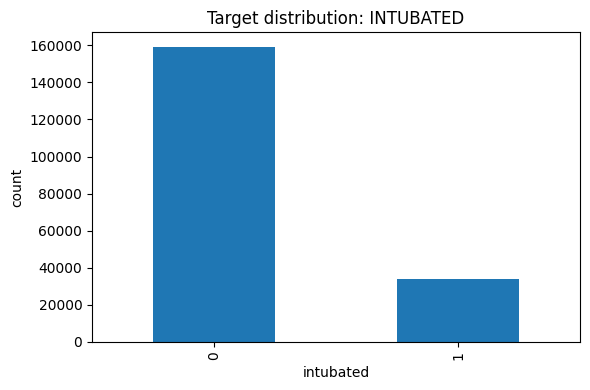

In [15]:
# ---------------------------------------------------------------------
# 4.1 Target distribution (imbalance)
# ---------------------------------------------------------------------
target_counts = df["intubated"].value_counts(dropna=False).sort_index()
target_rate = (df["intubated"] == 1).mean()

print("Target counts:")
display(target_counts.to_frame("count"))
print(f"Positive rate (intubated=1): {target_rate:.3%}")

plt.figure(figsize=(6,4))
target_counts.plot(kind="bar")
plt.title("Target distribution: INTUBATED")
plt.xlabel("intubated")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / "target_distribution.png", dpi=200)
plt.show()


In [16]:
# ---------------------------------------------------------------------
# 4.2 Missingness overview
# ---------------------------------------------------------------------
missing = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
missing = missing[missing > 0]

print(f"Columns with missing values: {len(missing)}")

if len(missing) == 0:
    print("✅ No missing values detected after recoding.")
else:
    display(missing.to_frame("% missing").head(25))

    plt.figure(figsize=(8, max(3, 0.25 * min(len(missing), 20))))
    missing.head(20).sort_values().plot(kind="barh")
    plt.title("Top 20 columns by missingness (%)")
    plt.xlabel("% missing")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "missingness_top20.png", dpi=200)
    plt.show()


Columns with missing values: 0
✅ No missing values detected after recoding.


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
age,192706.0,53.119207,19.452886,0.0,0.0,16.0,42.0,55.0,67.0,82.0,90.0,118.0


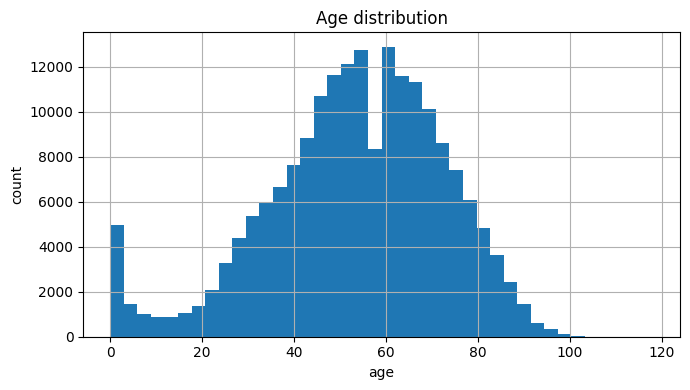

<Figure size 600x400 with 0 Axes>

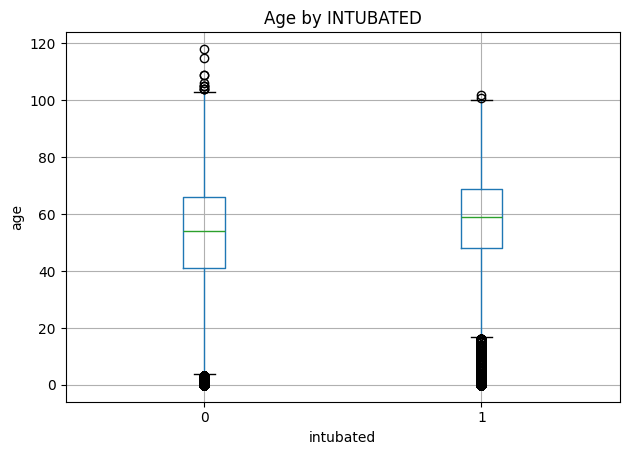

In [17]:
# ---------------------------------------------------------------------
# 4.3 Numeric summary (age-focused, if present)
# ---------------------------------------------------------------------
if "age" in df.columns:
    display(df["age"].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).to_frame().T)

    plt.figure(figsize=(7,4))
    df["age"].hist(bins=40)
    plt.title("Age distribution")
    plt.xlabel("age")
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "age_distribution.png", dpi=200)
    plt.show()

    # Age by class (boxplot) – quick outlier scan
    plt.figure(figsize=(6,4))
    df.boxplot(column="age", by="intubated")
    plt.title("Age by INTUBATED")
    plt.suptitle("")
    plt.xlabel("intubated")
    plt.ylabel("age")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "age_by_intubated_box.png", dpi=200)
    plt.show()
else:
    print("No 'age' column found; skipping age EDA.")


Binary feature count: 5


,class_0,class_1,abs_diff
intubed,0.0,1.0,1.0
pneumonia,0.566878,0.768095,0.201217
sex,0.417133,0.353518,0.063615
usmer,0.543238,0.561861,0.018623
patient_type,0.0,0.0,0.0


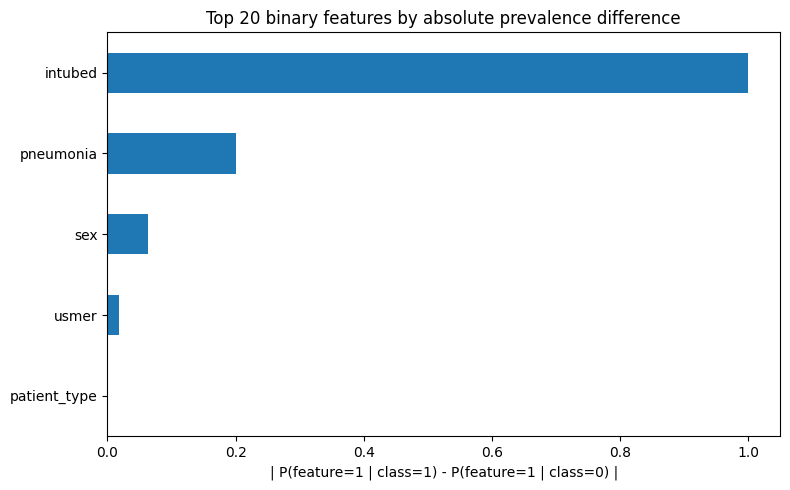

In [18]:
# ---------------------------------------------------------------------
# 4.4 Feature signal: prevalence differences for binary columns
# ---------------------------------------------------------------------
binary_cols = [c for c in df.columns if c not in ["intubated"] and str(df[c].dtype) == "Int64"]
print("Binary feature count:", len(binary_cols))

if len(binary_cols) > 0:
    # mean of binary cols by class = prevalence
    by_class = df.groupby("intubated")[binary_cols].mean().T
    by_class.columns = [f"class_{int(c)}" for c in by_class.columns]
    by_class["abs_diff"] = (by_class["class_1"] - by_class["class_0"]).abs()
    by_class = by_class.sort_values("abs_diff", ascending=False)

    display(by_class.head(20))

    plt.figure(figsize=(8, max(4, 0.25 * 20)))
    by_class.head(20)["abs_diff"].sort_values().plot(kind="barh")
    plt.title("Top 20 binary features by absolute prevalence difference")
    plt.xlabel("| P(feature=1 | class=1) - P(feature=1 | class=0) |")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "binary_feature_abs_diff_top20.png", dpi=200)
    plt.show()
else:
    print("No binary Int64 columns detected. If your dataset uses 1/2 coding, "
          "check the mapping in `safe_binary_map()`.")


,corr,abs_corr
intubed,1.000000,1.000000
pneumonia,0.156074,0.156074
clasiffication_final,-0.124715,0.124715
age,0.095533,0.095533
medical_unit,-0.049875,0.049875
sex,-0.049182,0.049182
pregnant,0.048970,0.048970
asthma,0.019600,0.019600
renal_chronic,0.018881,0.018881
icu,-0.018770,0.018770


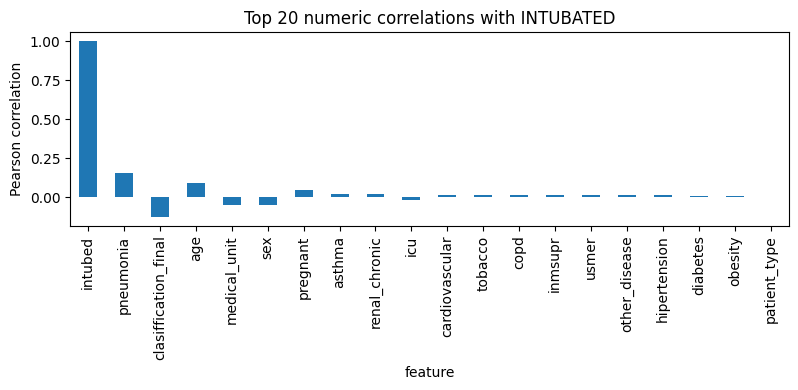

In [19]:
# ---------------------------------------------------------------------
# 4.5 Correlation with target (numeric columns)
#     Note: correlation is only a *screening* tool, not causation.
# ---------------------------------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "intubated" in numeric_cols:
    numeric_cols.remove("intubated")

if len(numeric_cols) > 0:
    corr = df[numeric_cols + ["intubated"]].corr(numeric_only=True)["intubated"].drop("intubated")
    corr_sorted = corr.abs().sort_values(ascending=False)

    display(pd.DataFrame({
        "corr": corr.loc[corr_sorted.index],
        "abs_corr": corr_sorted
    }).head(20))

    plt.figure(figsize=(8, 4))
    corr.loc[corr_sorted.index].head(20).plot(kind="bar")
    plt.title("Top 20 numeric correlations with INTUBATED")
    plt.xlabel("feature")
    plt.ylabel("Pearson correlation")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "corr_with_target_top20.png", dpi=200)
    plt.show()
else:
    print("No numeric columns found for correlation screening.")


***Summary of EDA***

- The target (`INTUBATED`) is typically **imbalanced** in clinical datasets, so downstream modelling should use:
  - Appropriate metrics (F1, recall, precision, PR‑AUC)
  - Class weighting or resampling (e.g., SMOTE) tested via cross‑validation
- Missingness should be handled carefully:
  - For high-missingness features, consider dropping or imputing (strategy depends on semantics)
- Age (if present) should be checked for **outliers** and potential binning
- Binary feature prevalence differences + correlation screening help identify candidate predictors for feature engineering


# 5.0 Save Clean Dataset + EDA Artefacts

We save a clean dataset snapshot (after minimal cleaning) and an EDA summary JSON for downstream notebooks.


In [ ]:
# ---------------------------------------------------------------------
# 5.1 Save clean dataset + summary
# ---------------------------------------------------------------------
clean_path = OUTPUT_DIR / "covid_clean.parquet"
summary_path = OUTPUT_DIR / "eda_summary.json"

# Save dataset (parquet keeps types better than CSV)
df.to_parquet(clean_path, index=False)

eda_summary = {
    "seed": SEED,
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "target_positive_rate": float((df["intubated"] == 1).mean()),
    "converted_binary_cols": converted,
    "top_missing_cols_pct": missing.head(20).to_dict() if 'missing' in globals() else {},
    "plots_saved": [
        "target_distribution.png",
        "missingness_top20.png",
        "age_distribution.png" if "age" in df.columns else None,
        "age_by_intubated_box.png" if "age" in df.columns else None,
        "binary_feature_abs_diff_top20.png",
        "corr_with_target_top20.png",
    ],
}
eda_summary["plots_saved"] = [p for p in eda_summary["plots_saved"] if p is not None]

with open(summary_path, "w") as f:
    json.dump(eda_summary, f, indent=2)

print("Saved:", clean_path)
print("Saved:", summary_path)
